In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pywt
import seaborn as sns

from numba import cuda

In [2]:
pd.__version__

'0.24.2'

# Import data

In [ ]:
data = pd.read_csv('SP-280-Leste.csv', sep=',',header=None)
data.head()

## Clean and organize dataset

### Organize the dataset

Organize the columns, remove some not useful data, rename the columns and convert each column to your correct unit.

### Date-time columns

Working with date-time date requires to change the index DataFrame to the column that contain Date-Time values


In [4]:
'''Organize'''
# Drop the column '0'
data = data.drop(columns=0)

# Rename columns
data = data.rename(columns={0:"ID", 1:"Data-Hora",2:"Fluxo[veic/h.faixa]", 3:"Velocidade[km/h]" })

# Calculate flow rate
data["Fluxo[veic/h.faixa]"] = data["Fluxo[veic/h.faixa]"] * 60 / 5 / 2 # two lanes

# Calculate Density
data["Densidade[veic/km.faixa]"] = data["Fluxo[veic/h.faixa]"] / data['Velocidade[km/h]']

# Convert to_datetime
data['Data-Hora'] = pd.to_datetime(data['Data-Hora'], format='%d/%m/%Y %H:%M')

'''Date-time column index'''
data.set_index('Data-Hora',inplace=True)
data.head()

,Fluxo[veic/h.faixa],Velocidade[km/h],Densidade[veic/km.faixa]
Data-Hora,,,
2011-09-01 00:00:00,222.0,89.0,2.494382
2011-09-01 00:05:00,288.0,82.0,3.512195
2011-09-01 00:10:00,156.0,85.0,1.835294
2011-09-01 00:15:00,282.0,81.0,3.481481
2011-09-01 00:20:00,312.0,82.0,3.804878


In [5]:
print(data.dtypes)
print(data.shape)

Fluxo[veic/h.faixa]         float64
Velocidade[km/h]            float64
Densidade[veic/km.faixa]    float64
dtype: object
(105408, 3)


### Missing values

Verifying some missing values in dataset

In [6]:
data[data.isna()['Velocidade[km/h]']]

,Fluxo[veic/h.faixa],Velocidade[km/h],Densidade[veic/km.faixa]
Data-Hora,,,
2011-10-16 00:45:00,0.0,NaN,NaN


In [7]:
data.isna().sum()

Fluxo[veic/h.faixa]          0
Velocidade[km/h]             1
Densidade[veic/km.faixa]    39
dtype: int64

In [8]:
data = data.fillna(0.0)
data.isna().sum()

Fluxo[veic/h.faixa]         0
Velocidade[km/h]            0
Densidade[veic/km.faixa]    0
dtype: int64

# Wavelet Analysis

## Introduction

In [9]:
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [10]:
t = 5#min
n = 288#data.size

while n>2:
    print(t,' min -> ', n)
    t *= 2
    n /= 2

5  min ->  288
10  min ->  144.0
20  min ->  72.0
40  min ->  36.0
80  min ->  18.0
160  min ->  9.0
320  min ->  4.5
640  min ->  2.25


## Applying in all dataset

In [11]:
cA, cD = pywt.dwt(data['Densidade[veic/km.faixa]'],'haar')

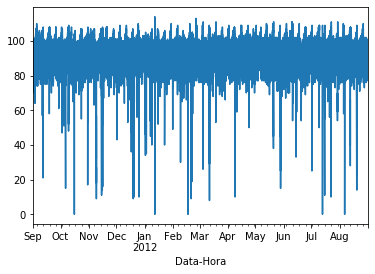

In [12]:
data['Velocidade[km/h]'].plot()

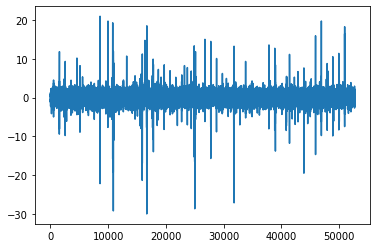

In [13]:
plt.plot(cD)

In [14]:
nlevel = 8
res = pywt.wavedec(data['Velocidade[km/h]'],'haar',level=nlevel)
#res

Mean =  1474.7189017  | Std =  54.6979215969
Mean =  -1.57296723301  | Std =  45.1972949026
Mean =  -0.774577983457  | Std =  38.032904051
Mean =  -0.0578324225865  | Std =  28.4511568726
Mean =  -0.0942379711417  | Std =  15.9762424337
Mean =  0.0622343655131  | Std =  7.83338162127
Mean =  0.00708394771681  | Std =  4.829487343
Mean =  -0.0099043715847  | Std =  3.268703566
Mean =  -0.0327364250549  | Std =  2.80558548781


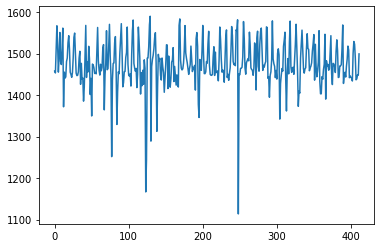

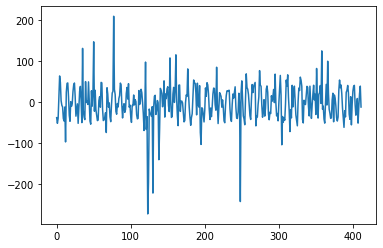

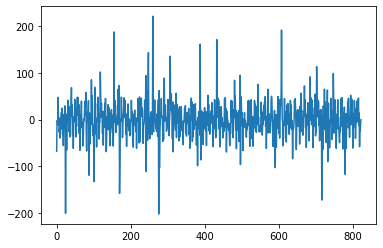

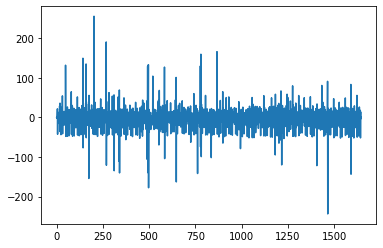

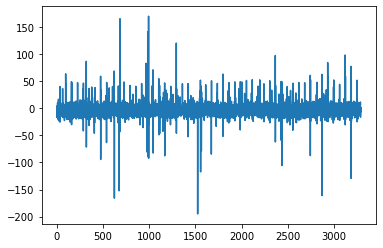

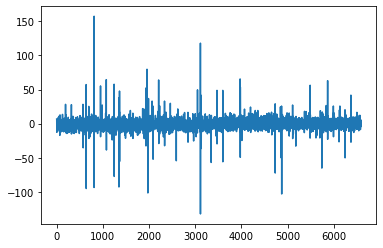

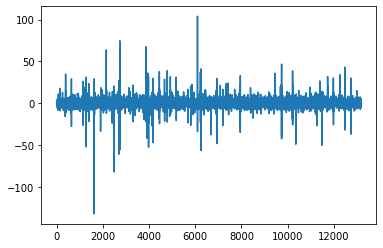

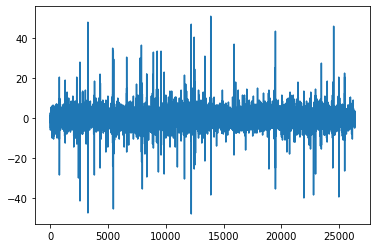

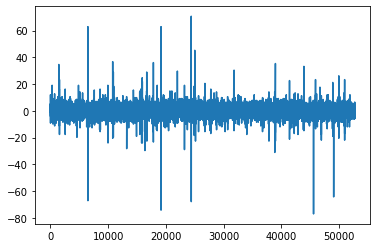

In [15]:
for i in range(nlevel+1):
    plt.figure()
    plt.plot(res[i])
    print('Mean = ', res[i].mean(),' | Std = ', res[i].std())

In [16]:
#level = 0
for level in range(nlevel+1):
    highvalue = res[level].mean() + 1.5 * res[level].std()
    lowvalue = res[level].mean() - 1.5 * res[level].std()

    res[level] = pywt.threshold(res[level], lowvalue, 'greater', lowvalue)
    res[level] = pywt.threshold(res[level], highvalue, 'less', highvalue)

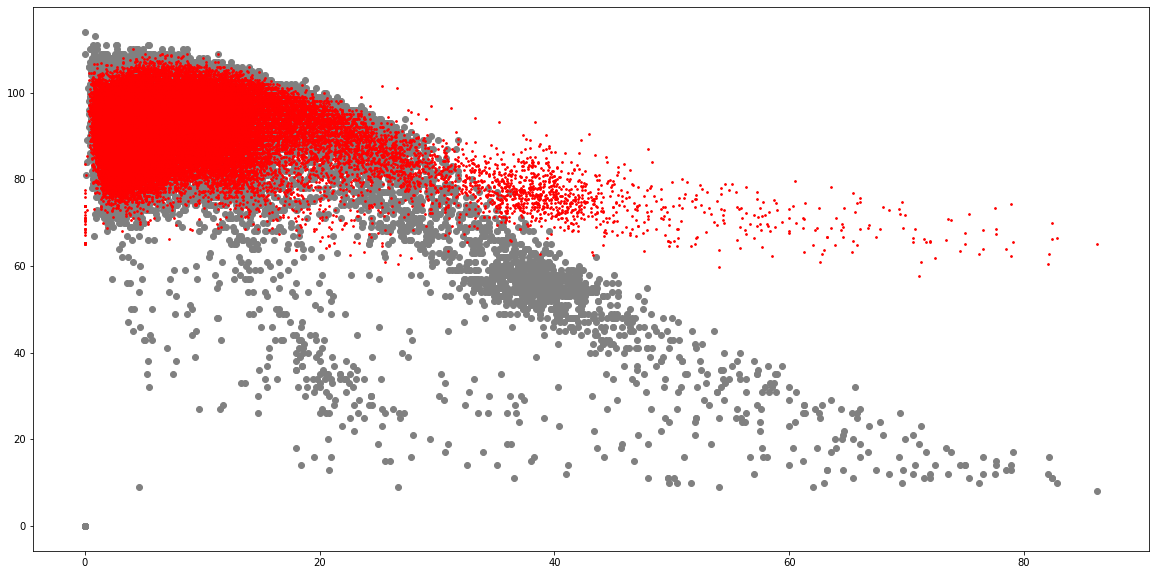

In [17]:
signal = pywt.waverec(res,'haar')

plt.figure(figsize = (20,10))
plt.scatter(data['Densidade[veic/km.faixa]'], data['Velocidade[km/h]'], color='grey')
plt.scatter(data['Densidade[veic/km.faixa]'], signal, s=3, color='red')

## Applying in each day

In [18]:
db = data[0:288]

# Plot Speed-Time and Flow-Time
fig = plt.figure()
plt.plot(db["Data-Hora"],db['Fluxo[veic/h.faixa]'])

fig = plt.figure()
plt.plot(db["Data-Hora"],db['Velocidade[km/h]'])

KeyError: 'Data-Hora'

<Figure size 432x288 with 0 Axes>

In [ ]:
cA, cD = pywt.dwt(db['Fluxo[veic/h.faixa]'] ,'haar')
plt.plot(cA)
plt.figure()
plt.plot(cD,color='orange')

In [ ]:
cA, cD = pywt.dwt(db['Velocidade[km/h]'] ,'haar')
plt.plot(cA)
plt.figure()
plt.plot(cD,color='orange')

In [ ]:
def scatterHist(x,y):
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))

    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    ax_scatter.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 20
    limx = np.ceil(np.abs(x).max() / binwidth) * binwidth
    limy = np.ceil(np.abs(y).max() / binwidth) * binwidth
    ax_scatter.set_xlim((0, limx))
    ax_scatter.set_ylim((0, limy))

    binsx = np.arange(0, limx + binwidth, binwidth)
    binsy = np.arange(0, limy + binwidth, binwidth)
    ax_histx.hist(x, bins=binsx)
    ax_histy.hist(y, bins=binsy, orientation='horizontal')

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())

    plt.show()

In [ ]:
scatterHist(data['Fluxo[veic/h.faixa]'], data['Velocidade[km/h]'])